In [1]:
import warnings
import os
import IPython
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
import keras_tuner as kt

error = 'mean_squared_error'
warnings.filterwarnings("ignore")
data_path = './Data/data'
train_path = './Data/train'
valid_path = './Data/valid'
test_path = './Data/test'
ERROR = 'mean_squared_error'

def performance_measure(y_true, y_pred):
    m_ = eval(error)
    print('weighted_{}: {:.5f}'.format(
        error, m_(y_true, y_pred, sample_weight=abs(y_true) / np.sum(abs(y_true)))
    )
         )
    return m_(y_true, y_pred, sample_weight=abs(y_true) / np.sum(abs(y_true)))

def simulation(y_true, y_pred, ids, ax=None, title=''):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
        
    scheme = y_pred.copy()
    
    scheme = np.where(scheme < 0, -1, scheme)
    scheme = np.where(scheme == 0, 0, scheme)
    scheme = np.where(scheme > 0, 1, scheme)
    
    daily_returns = scheme * y_true
    cum_returns = np.cumprod(1.0 + daily_returns)
    sharpe = np.mean(daily_returns) / np.std(daily_returns)
    
    if ax is None:
        plt.plot(ids, cum_returns)
        plt.title(title + ' sharpe ratio = {:.5f}'.format(sharpe))
    else:
        ax.plot(ids, cum_returns)
        ax.set_title(title + ' sharpe ratio = {:.5f}'.format(sharpe))
    return sharpe

class DataPipe:
    
    def __init__(self, all_stocks_):
        self.all_stocks = all_stocks_
        self.data_window_size = 60
        self.data_df = None
        self.transformers = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        self.transformers_file = './final_model/transformers.txt'
    
    def train(self, train_path_):
        self._getData(train_path_)
        self._generateFeatures()
        X_train_stack_ = np.array([])
        y_train_stack_ = np.array([])
        ids_train_stack_ = np.array([])
        for stock_ in self.all_stocks:
            X_train_, y_train_, ids_train_ = self._extractStock(stock_)
            self.transformers.fit(X_train_)
            #####
            if stock_ == 'AAPL':
                self._save_transformers()
            #####
            X_train_ = self.transformers.transform(X_train_)
            X_train_, y_train_, ids_train_ = self._generateDataWindow(X_train_, y_train_, ids_train_)
            if stock_ == self.all_stocks[0]:
                X_train_stack_ = X_train_
                y_train_stack_ = y_train_
                ids_train_stack_ = ids_train_
            else:
                X_train_stack_ = np.vstack((X_train_stack_, X_train_))
                y_train_stack_ = np.hstack((y_train_stack_, y_train_))
                ids_train_stack_ = np.hstack((ids_train_stack_, ids_train_))
        print('Windowed X_train shape: ', X_train_stack_.shape)
        print('Windowed y_train shape: ', y_train_stack_.shape)
        return X_train_stack_, y_train_stack_, ids_train_stack_

    def val(self, valid_path_):
        self._getData(valid_path_)
        self._generateFeatures()
        
        X_valid_, y_valid_, ids_valid_ = self._extractStock('AAPL')
        #####
        self._load_transformers()
        #####
        X_valid_ = self.transformers.transform(X_valid_)
        X_valid_, y_valid_, ids_valid_ = self._generateDataWindow(X_valid_, y_valid_, ids_valid_)
        print('Windowed X_valid shape: ', X_valid_.shape)
        print('Windowed y_valid shape: ', y_valid_.shape)
        return X_valid_, y_valid_, ids_valid_
    
    def test(self, test_path_):
        self._getData(test_path_)
        self._generateFeatures()
        X_test_, y_test_, ids_test_ = self._extractStock('AAPL') 
        #####
        self._load_transformers()
        #####
        X_test_ = self.transformers.transform(X_test_)
        X_test_, y_test_, ids_test_ = self._generateDataWindow(X_test_, y_test_, ids_test_)
        
        print('Windowed X_test shape: ', X_test_.shape)
        print('Windowed y_test shape: ', y_test_.shape)
        return X_test_, y_test_, ids_test_
        
    
    def _getData(self, path_):
        
        for stock_ in self.all_stocks:
            d_ = pd.read_csv(path_ + '/{}.csv'.format(stock_))
            d_['return'] = d_['Close'].pct_change()
            d_['Dt'] = pd.to_datetime(d_['Dt'])
            d_.columns = [d_.columns[0]] + [stock_ + '_' + i for i in d_.columns[1:]]
            if stock_ == self.all_stocks[0]:
                self.data_df = d_
            else:
                self.data_df = pd.merge(self.data_df, d_, how='left', left_on='Dt', right_on='Dt')

        self.data_df = self.data_df.set_index('Dt')
        pass
    
    def _generateFeatures(self):
        
        self.data_df['day_of_week'] = self.data_df.index.dayofweek
        self.data_df['week'] = self.data_df.index.isocalendar().week
        self.data_df['month'] = self.data_df.index.month
        
        indices_ = self.data_df['day_of_week'].values
        depth_ = 5
        ohe_col_name_ = ['IS_DAY' + str(i + 1) + '(t)' for i in range(depth_)]
        self.data_df[ohe_col_name_] = tf.one_hot(indices_, depth_).numpy()

        indices_ = self.data_df['week'].values - 1
        depth_ = 52
        ohe_col_name_ = ['IS_WEEK' + str(i + 1) + '(t)' for i in range(depth_)]
        self.data_df[ohe_col_name_] = tf.one_hot(indices_, depth_).numpy()

        indices_ = self.data_df['month'].values - 1
        depth_ = 12
        ohe_col_name_ = ['IS_MONTH' + str(i + 1) + '(t)' for i in range(depth_)]
        self.data_df[ohe_col_name_] = tf.one_hot(indices_, depth_).numpy()
    
        for stock_ in self.all_stocks:
            self.data_df[stock_ + '_Close(t-1)'] = self.data_df[stock_ + '_Close'].shift(1)
            self.data_df[stock_ + '_Volume(t-1)'] = self.data_df[stock_ + '_Volume'].shift(1)
            self.data_df[stock_ + '_return(t-1)'] = self.data_df[stock_ + '_return'].shift(1)

            self.data_df[stock_ + '_STD(5)'] = self.data_df[stock_ + '_Close(t-1)'].rolling(5).std()
            self.data_df[stock_ + '_MA(5)'] = self.data_df[stock_ + '_Close(t-1)'].rolling(5).mean()
            self.data_df[stock_ + '_BIAS(5)'] = self.data_df[stock_ + '_Close(t-1)'] * (
                (self.data_df[stock_ + '_Close(t-1)'] - self.data_df[stock_ + '_MA(5)']) / self.data_df[stock_ + '_MA(5)']
            ) * 100

        pass
    
    def _extractStock(self, this_stock_):
        data_df_ = self.data_df.copy()
        data_df_ = data_df_[[this_stock_ + '_return'] + [i for i in data_df_.columns if '(' in i]]
        
        for ben_stock_ in self.all_stocks:
            if this_stock_ == ben_stock_:
                data_df_['corr_with_' + ben_stock_] = 1
            else:
                data_df_['corr_with_' + ben_stock_] = data_df_[
                    [this_stock_ + '_Close(t-1)', ben_stock_ + '_Close(t-1)']
                ].rolling(5).corr().loc[(slice(None), this_stock_ + '_Close(t-1)'), ben_stock_ + '_Close(t-1)'].values
        
        data_df_ = data_df_.iloc[5:, :]
        
        assert data_df_.isna().sum().sum() == 0
        return data_df_.drop(this_stock_ + '_return', axis=1).values, data_df_[this_stock_ + '_return'].values, data_df_.index.values
    
    def _generateDataWindow(self, X_train_, y_train_, ids_train_):
        data_window_size_ = self.data_window_size
        
        num_samples_ = X_train_.shape[0] - data_window_size_ + 1
        start_index_ = data_window_size_ - 1
        num_features_ = X_train_.shape[1]

        X_train_windowed_ = np.zeros(shape=(num_samples_, data_window_size_, num_features_))

        for i_ in range(start_index_, X_train_.shape[0]):
            X_train_windowed_[i_ - data_window_size_ + 1, :, :] = X_train_[i_ - data_window_size_ + 1: i_ + 1, :]

        y_train_windowed_ = y_train_[start_index_:]
        ids_train_windowed_ = ids_train_[start_index_:]

        X_train_ = X_train_windowed_
        y_train_ = y_train_windowed_
        ids_train_ = ids_train_windowed_
        return X_train_, y_train_, ids_train_
    
    def _save_transformers(self):
        f = open(self.transformers_file, 'wb')
        pickle.dump(self.transformers, f)
        f.close()
        print('transformers saved at ' + self.transformers_file)
        pass

    def _load_transformers(self):
        f = open(self.transformers_file, 'rb')
        self.transformers = pickle.load(f)
        f.close()
        pass

In [2]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE
    all_stocks = ['AAPL', 'ADBE', 'CSCO', 'IBM', 'INTC','MSFT','NVDA',
                  'SPY','XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
    data = DataPipe(all_stocks)
    X_test, y_test, ids_test = data.test(test_dir)
    y_test_pred = model.predict(X_test)
    
    predictions = y_test_pred[-200:]
    ids = ids_test[-200:]
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
#my_model = fm1_lstm_best.model # CHANGE None to your model !

#saveModel(my_model, model_path)

In [3]:
holdout_dir = os.path.join(".", "Data", "sample")
predicts, ids = MyModel(holdout_dir, model_path)

Windowed X_test shape:  (187, 60, 188)
Windowed y_test shape:  (187,)


weighted_mean_squared_error: 0.00110


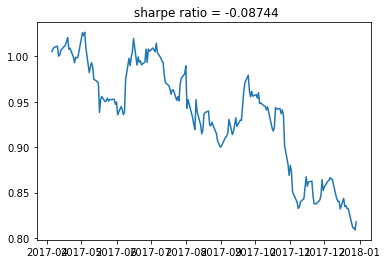

In [4]:
real = pd.read_csv(holdout_dir + '/AAPL.csv')
real['return'] = real['Close'].pct_change()
real['Dt'] = pd.to_datetime(real['Dt'])
real = real.set_index('Dt')
real_labels = real.loc[ids, 'return'].values
_ = performance_measure(real_labels, predicts)
_ = simulation(real_labels, predicts, ids)

In [5]:
print('Done')

Done
